This code is originally from GeoFM288KC, Fall 2025

Buffalo NDVI Time-Series → Spatio-Temporal Regression

A pipeline for:

Searching Sentinel-2 on STAC (Planetary Computer / EarthSearch)

Computing NDVI for an AOI (Buffalo bounding box)

Saving NDVI GeoTIFFs and a metadata CSV

Resampling / aligning all NDVI rasters to a common grid

Building temporal train/val/test splits

A PyTorch Dataset/DataLoader that yields temporal patches with temporal encodings

A CNN+GRU spatio-temporal regressor

Training loop (plain PyTorch) and inference

Visualizations: time-series, NDVI map, patch gallery, predicted vs true


In [8]:
# 
# PREPEND THIS CELL BEFORE TRAINING CELL
# SAFE NDVI EXTRACTION → SAVE TIFFS → WRITE METADATA CSV
# 
import os
from pathlib import Path
import numpy as np
import rasterio
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds
from shapely.geometry import box
import pystac_client
import planetary_computer as pc
import pandas as pd
import time

# ------------------------------------------------------------
# CONFIG — Buffalo NY
# ------------------------------------------------------------
DATA_PATH = Path(os.path.expanduser("~/zijun_li/geo288kc/GEOG-288KC-geospatial-foundation-models/tests"))

NDVI_DIR = DATA_PATH / "buffalo_ndvi"
NDVI_DIR.mkdir(parents=True, exist_ok=True)

METADATA_CSV = DATA_PATH / "buffalo_ndvi_2024.csv"

# Buffalo bounding box
AOI_BBOX = [-78.90, 42.80, -78.78, 42.95]

DATETIME_RANGE = "2024-01-01/2024-12-31"
MAX_ITEMS = 200

EPS = 1e-6


# ------------------------------------------------------------
# CONNECT TO PLANETARY COMPUTER
# ------------------------------------------------------------
client = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)

search = client.search(
    collections=["sentinel-2-l2a", "sentinel-2-l2a-cogs"],
    bbox=AOI_BBOX,
    datetime=DATETIME_RANGE,
    query={"eo:cloud_cover": {"lt": 30}},
    max_items=MAX_ITEMS,
)

items = list(search.items())
print("STAC items found:", len(items))
if len(items) == 0:
    raise RuntimeError("No STAC items found. Expand AOI/date range.")

# ------------------------------------------------------------
# HELPER: pick red + nir hrefs
# ------------------------------------------------------------
def get_band_hrefs(item):
    assets = item.assets

    # Common
    if "B04" in assets and "B08" in assets:
        return assets["B04"].href, assets["B08"].href

    # EarthSearch style
    if "red" in assets and "nir" in assets:
        return assets["red"].href, assets["nir"].href

    # Analytic (multi-band) COG
    if "analytic" in assets:
        return assets["analytic"].href, "ANALYTIC"

    raise KeyError("No usable red/nir found")

# ------------------------------------------------------------
# MAIN EXTRACTION LOOP
# ------------------------------------------------------------
aoi_geom = box(*AOI_BBOX)
metadata = []
start_time = time.time()

for idx, item in enumerate(items):
    try:
        item = pc.sign(item)

        # --------------------------
        # Select assets
        # --------------------------
        try:
            red_href, nir_href = get_band_hrefs(item)
        except KeyError:
            print(f"[{idx}] Skip: no red/nir")
            continue

        date = item.properties.get("datetime", "")[:10]
        item_id = item.id.replace("/", "_")
        out_name = f"ndvi_{date}_{item_id}.tif"
        out_path = NDVI_DIR / out_name

        # --------------------------
        # Skip existing
        # --------------------------
        if out_path.exists():
            metadata.append({"path": str(out_path), "date": date})
            print(f"[{idx}] Exists: {out_name}")
            continue

        # --------------------------
        # READ RED BAND
        # --------------------------
        with rasterio.open(red_href) as src_red:
            # AOI bounds → source CRS
            aoi_src_bounds = transform_bounds(
                "EPSG:4326",
                src_red.crs,
                *AOI_BBOX,
                densify_pts=21,
            )
            red_window = from_bounds(*aoi_src_bounds, transform=src_red.transform)
            red = src_red.read(1, window=red_window).astype("float32")
            red_transform = src_red.window_transform(red_window)
            red_crs = src_red.crs

        if red.size == 0:
            print(f"[{idx}] Skip: empty RED window")
            continue

        # --------------------------
        # READ NIR BAND
        # --------------------------
        if nir_href == "ANALYTIC":
            with rasterio.open(red_href) as src_multi:
                # Sentinel-2 analytic COG band order:
                # 1: B02, 2: B03, 3: B04, 4: B08, ...
                nir = src_multi.read(4, window=red_window).astype("float32")
                nir_transform = red_transform
                nir_crs = src_multi.crs
        else:
            with rasterio.open(nir_href) as src_nir:
                nir = src_nir.read(1, window=red_window).astype("float32")
                nir_transform = src_nir.window_transform(red_window)
                nir_crs = src_nir.crs

        if nir.size == 0:
            print(f"[{idx}] Skip: empty NIR window")
            continue

        # --------------------------
        # ALIGN
        # --------------------------
        if red.shape != nir.shape:
            print(f"[{idx}] Skip: shape mismatch {red.shape} vs {nir.shape}")
            continue

        # --------------------------
        # NDVI
        # --------------------------
        red[red <= 0] = np.nan
        nir[nir <= 0] = np.nan
        ndvi = (nir - red) / (nir + red + EPS)

        if np.all(np.isnan(ndvi)):
            print(f"[{idx}] Skip: NDVI all NaN")
            continue

        # --------------------------
        # WRITE NDVI TIFF
        # --------------------------
        profile = {
            "driver": "GTiff",
            "height": ndvi.shape[0],
            "width": ndvi.shape[1],
            "count": 1,
            "dtype": "float32",
            "crs": red_crs,
            "transform": red_transform,
            "compress": "lzw",
        }

        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(ndvi, 1)

        metadata.append({"path": str(out_path), "date": date})
        print(f"[{idx}] Saved: {out_name}")

    except Exception as e:
        print(f"[{idx}] Skipping: {e}")
        continue

# ------------------------------------------------------------
# WRITE METADATA CSV
# ------------------------------------------------------------
if len(metadata) == 0:
    raise RuntimeError("No NDVI tiles produced.")

df = (
    pd.DataFrame(metadata)
    .drop_duplicates(subset=["path"])
    .sort_values("date")
    .reset_index(drop=True)
)
df.to_csv(METADATA_CSV, index=False)

print("\n=======================================")
print(" NDVI extraction complete")
print(" Saved tiles:", len(df))
print(" CSV:", METADATA_CSV)
print(" Time: %.1f sec" % (time.time() - start_time))
print("=======================================")


STAC items found: 33
[0] Saved: ndvi_2024-11-13_S2B_MSIL2A_20241113T160429_R097_T17TPH_20241114T075919.tif
[1] Saved: ndvi_2024-11-03_S2B_MSIL2A_20241103T160339_R097_T17TPH_20241103T202424.tif
[2] Saved: ndvi_2024-10-22_S2A_MSIL2A_20241022T161321_R140_T17TPH_20241022T215045.tif
[3] Saved: ndvi_2024-10-19_S2A_MSIL2A_20241019T160301_R097_T17TPH_20241019T221150.tif
[4] Saved: ndvi_2024-10-17_S2B_MSIL2A_20241017T161159_R140_T17TPH_20241017T202823.tif
[5] Saved: ndvi_2024-10-04_S2B_MSIL2A_20241004T160029_R097_T17TPH_20241004T202542.tif
[6] Saved: ndvi_2024-09-22_S2A_MSIL2A_20240922T161001_R140_T17TPH_20240922T215405.tif
[7] Saved: ndvi_2024-09-12_S2A_MSIL2A_20240912T160901_R140_T17TPH_20240912T215651.tif
[8] Saved: ndvi_2024-09-04_S2B_MSIL2A_20240904T155819_R097_T17TPH_20240904T214205.tif
[9] Saved: ndvi_2024-08-30_S2A_MSIL2A_20240830T155901_R097_T17TPH_20240830T215952.tif
[10] Saved: ndvi_2024-08-25_S2B_MSIL2A_20240825T155819_R097_T17TPH_20240825T202603.tif
[11] Saved: ndvi_2024-08-15_S2B_

In [9]:
# 
# NDVI -> TIMESERIES -> TRAIN/INFER 
# 
import os
from pathlib import Path
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import pandas as pd
import math, random, time
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score

#  CONFIG 
DATA_PATH = Path(os.path.expanduser('~/zijun_li/geo288kc/GEOG-288KC-geospatial-foundation-models/tests'))

# --- Buffalo ---
METADATA_CSV = DATA_PATH / "buffalo_ndvi_2024.csv"
NDVI_DIR = DATA_PATH / "buffalo_ndvi"
RESAMP_DIR = DATA_PATH / "buffalo_ndvi_resampled"
# ---------------------------

RESAMP_DIR.mkdir(parents=True, exist_ok=True)

# model / dataset params
SEQ_LEN = 6
PRED_HORIZON = 1
PATCH_SIZE = 64
SAMPLES_PER_WINDOW = 200
BATCH_SIZE = 8
NUM_WORKERS = 2
LR = 1e-3
MAX_EPOCHS = 10
SEED = 42
MIN_VALID_FRACTION = 0.02  # drop rasters with <2% valid pixels

torch.manual_seed(SEED); random.seed(SEED); np.random.seed(SEED)

#  Utilities 
def load_metadata(csv_path=METADATA_CSV):
    df = pd.read_csv(csv_path)
    if 'path' not in df.columns or 'date' not in df.columns:
        raise RuntimeError("metadata CSV must have 'path' and 'date' columns")
    df = df.dropna(subset=['path','date']).copy()
    df['path'] = df['path'].astype(str)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    return df

#  Step 1: load metadata 
df = load_metadata(METADATA_CSV)
print("Total scenes listed:", len(df))
if len(df) < (SEQ_LEN + PRED_HORIZON):
    raise RuntimeError("Not enough timesteps for requested seq_len + horizon.")

#  Step 2: build reference grid from first raster 
first_path = Path(df.iloc[0]['path'])
if not first_path.exists():
    raise FileNotFoundError(f"First NDVI file does not exist: {first_path}")

with rasterio.open(first_path) as src0:
    ref_crs = src0.crs
    ref_transform = src0.transform
    ref_width = src0.width
    ref_height = src0.height
print(f"Reference grid: crs={ref_crs}, size={ref_height}x{ref_width}")

#  Step 3: resample all rasters to reference grid (if not already) 
resampled_paths = []
print("Resampling (or reusing) rasters to reference grid ...")
t0 = time.time()
for idx, row in df.iterrows():
    src_p = Path(row['path'])
    out_p = RESAMP_DIR / f"resamp_{idx:04d}_{src_p.name}"
    if out_p.exists():
        resampled_paths.append(str(out_p))
        continue
    if not src_p.exists():
        print("Skipping missing file:", src_p)
        continue
    with rasterio.open(src_p) as src:
        src_arr = src.read(1)
        dst = np.full((ref_height, ref_width), np.nan, dtype=np.float32)
        try:
            reproject(
                source=src_arr,
                destination=dst,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=ref_transform,
                dst_crs=ref_crs,
                resampling=Resampling.bilinear,
                num_threads=2
            )
        except Exception as e:
            print("Reproject failed for", src_p, ":", e)
            continue

        profile = src.profile.copy()
        profile.update({
            "crs": ref_crs,
            "transform": ref_transform,
            "width": ref_width,
            "height": ref_height,
            "count": 1,
            "dtype": "float32",
            "compress": "lzw"
        })
        with rasterio.open(out_p, "w", **profile) as dstf:
            dstf.write(dst.astype(np.float32), 1)
    resampled_paths.append(str(out_p))

t1 = time.time()
print(f"Resampled {len(resampled_paths)} rasters in {t1-t0:.1f}s")

#  Step 4: compute valid fraction per resampled raster and filter 
print("Checking valid pixel fraction and filtering empty scenes...")
valid_records = []
for p, date in zip(resampled_paths, df['date'].iloc[:len(resampled_paths)]):
    try:
        with rasterio.open(p) as src:
            arr = src.read(1)
            # valid pixels are finite and within NDVI range [-1,1]
            valid_mask = np.isfinite(arr) & (arr > -1.1) & (arr < 1.1)
            valid_frac = float(valid_mask.sum()) / (arr.size)
            if valid_frac >= MIN_VALID_FRACTION:
                valid_records.append({"path": p, "date": date})
            else:
                # remove tiny files to save space/time (optional)
                print(f"Filtering out {p} (valid fraction {valid_frac:.3f})")
    except Exception as e:
        print("Error reading", p, e)

df_clean = pd.DataFrame(valid_records).sort_values('date').reset_index(drop=True)
print("Usable scenes after filtering:", len(df_clean))
if len(df_clean) < (SEQ_LEN + PRED_HORIZON):
    raise RuntimeError("Not enough valid timesteps after filtering.")

#  Step 5: temporal splits (recompute from cleaned df) 
n = len(df_clean)
train_end = int(0.6 * n)
val_end = int(0.8 * n)
train_df = df_clean.iloc[:train_end].reset_index(drop=True)
val_df = df_clean.iloc[train_end:val_end].reset_index(drop=True)
test_df = df_clean.iloc[val_end:].reset_index(drop=True)
print("Splits -> train:", len(train_df), "val:", len(val_df), "test:", len(test_df))

#  Temporal features helper 
def temporal_features(dates):
    arr = []
    for d in dates:
        doy = d.timetuple().tm_yday
        sin_doy = math.sin(2 * math.pi * doy / 365.25)
        cos_doy = math.cos(2 * math.pi * doy / 365.25)
        arr.append((sin_doy, cos_doy, d.year))
    arr = np.array(arr, dtype=np.float32)
    arr[:,2] = (arr[:,2] - arr[:,2].min()) / max(1.0, (arr[:,2].max() - arr[:,2].min()))
    return arr

#  Dataset 
class NDVITimeSeriesDataset(Dataset):
    def __init__(self, df_timeindex, seq_len=SEQ_LEN, horizon=PRED_HORIZON, patch_size=PATCH_SIZE,
                 samples_per_window=SAMPLES_PER_WINDOW, max_patch_attempts=10):
        self.df = df_timeindex.reset_index(drop=True)
        self.seq_len = seq_len
        self.horizon = horizon
        self.patch_size = patch_size
        self.samples_per_window = samples_per_window
        self.n_windows = max(0, len(self.df) - (self.seq_len + self.horizon) + 1)
        if self.n_windows == 0:
            raise RuntimeError("Not enough timesteps for seq_len + horizon")
        # open first image to get dims
        with rasterio.open(self.df.iloc[0]['path']) as s:
            self.H = s.height; self.W = s.width
        self.max_i = self.H - self.patch_size
        self.max_j = self.W - self.patch_size
        if self.max_i <= 0 or self.max_j <= 0:
            raise RuntimeError("Patch size too large for raster dims")
        self.max_patch_attempts = max_patch_attempts

    def __len__(self):
        return self.n_windows * self.samples_per_window

    def _read_patch_safe(self, tif_path, i0, j0):
        with rasterio.open(tif_path) as ds:
            win = rasterio.windows.Window(j0, i0, self.patch_size, self.patch_size)
            arr = ds.read(1, window=win).astype(np.float32)
            # convert nodata or inf to nan
            if ds.nodata is not None:
                arr[arr == ds.nodata] = np.nan
            arr[~np.isfinite(arr)] = np.nan
            # clamp to valid NDVI range and leave NaNs for now
            arr = np.clip(arr, -1.0, 1.0)
            return arr

    def __getitem__(self, idx):
        window_idx = idx // self.samples_per_window
        attempts = 0
        while True:
            # pick random patch
            i0 = random.randint(0, self.max_i)
            j0 = random.randint(0, self.max_j)

            start = window_idx
            end = start + self.seq_len
            target_idx = end + (self.horizon - 1)

            seq_paths = self.df['path'].iloc[start:end].tolist()
            seq_dates = self.df['date'].iloc[start:end].tolist()
            target_path = self.df['path'].iloc[target_idx]

            # read seq patches
            seq_patches = [self._read_patch_safe(p, i0, j0) for p in seq_paths]
            target_patch = self._read_patch_safe(target_path, i0, j0)

            # If target_patch is all-NaN, try another random patch (up to attempts)
            if not np.isfinite(target_patch).any():
                attempts += 1
                if attempts >= self.max_patch_attempts:
                    # fallback: compute target as mean of nearest valid pixel across whole target raster
                    with rasterio.open(target_path) as ds:
                        full = ds.read(1).astype(np.float32)
                        if ds.nodata is not None:
                            full[full == ds.nodata] = np.nan
                        full[~np.isfinite(full)] = np.nan
                        if np.isfinite(full).any():
                            y = float(np.nanmean(np.clip(full, -1.0, 1.0)))
                        else:
                            y = 0.0
                    # convert seq patches -> numeric (nan->0)
                    seq_patches = [np.nan_to_num(p, nan=0.0) for p in seq_patches]
                    X = np.stack(seq_patches, axis=0)
                    X = np.expand_dims(X, 1)
                    X = torch.from_numpy(X).float()
                    T = torch.from_numpy(temporal_features(seq_dates)).float()
                    y = torch.tensor(y).float().unsqueeze(0)
                    return X, T, y
                else:
                    continue  # try again with another random patch
            else:
                # valid target: compute mean over finite values
                y = float(np.nanmean(target_patch))
                # replace nan in seq patches with zero (safe)
                seq_patches = [np.nan_to_num(p, nan=0.0) for p in seq_patches]
                X = np.stack(seq_patches, axis=0)
                X = np.expand_dims(X, 1)
                X = torch.from_numpy(X).float()
                T = torch.from_numpy(temporal_features(seq_dates)).float()
                y = torch.tensor(y).float().unsqueeze(0)
                return X, T, y

#  DataLoaders 
def make_loaders(train_df, val_df, test_df):
    train_ds = NDVITimeSeriesDataset(train_df, seq_len=SEQ_LEN, patch_size=PATCH_SIZE, samples_per_window=200)
    val_ds = NDVITimeSeriesDataset(val_df, seq_len=SEQ_LEN, patch_size=PATCH_SIZE, samples_per_window=50)
    test_ds = NDVITimeSeriesDataset(test_df, seq_len=SEQ_LEN, patch_size=PATCH_SIZE, samples_per_window=50)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    return train_loader, val_loader, test_loader, train_ds, val_ds, test_ds

train_loader, val_loader, test_loader, train_ds, val_ds, test_ds = make_loaders(train_df, val_df, test_df)
print("Dataset sizes (windows*sample_per_window):", len(train_ds), len(val_ds), len(test_ds))

#  Model 
class CNNBackbone(nn.Module):
    def __init__(self, in_ch=1, feat_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(128, feat_dim)
    def forward(self, x):
        z = self.conv(x).view(x.size(0), -1)
        return self.fc(z)

class SpatioTemporalRegressor(nn.Module):
    def __init__(self, feat_dim=128, temp_feat_dim=3, hidden=128):
        super().__init__()
        self.backbone = CNNBackbone(in_ch=1, feat_dim=feat_dim)
        self.gru = nn.GRU(input_size=feat_dim + temp_feat_dim, hidden_size=hidden, batch_first=True)
        self.head = nn.Sequential(nn.Linear(hidden, hidden//2), nn.ReLU(), nn.Linear(hidden//2, 1))
    def forward(self, X, T):
        B, S, C, H, W = X.shape
        X = X.view(B*S, C, H, W)
        feats = self.backbone(X)
        feats = feats.view(B, S, -1)
        inp = torch.cat([feats, T], dim=-1)
        out, _ = self.gru(inp)
        last = out[:, -1, :]
        y = self.head(last)
        return y

#  Training 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SpatioTemporalRegressor(feat_dim=128, temp_feat_dim=3, hidden=128).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

print("Starting training on device:", device)
for epoch in range(MAX_EPOCHS):
    t0 = time.time()
    model.train()
    train_losses = []
    for X, T, y in train_loader:
        X = X.to(device); T = T.to(device); y = y.to(device)
        opt.zero_grad()
        y_hat = model(X, T)
        # safety: replace any NaNs in predictions with zeros (shouldn't be necessary, but safe)
        if not torch.isfinite(y_hat).all():
            y_hat = torch.nan_to_num(y_hat, nan=0.0, posinf=0.0, neginf=0.0)
        if not torch.isfinite(y).all():
            y = torch.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
        loss = loss_fn(y_hat.view(-1), y.view(-1))
        if not torch.isfinite(loss):
            print("NaN loss encountered — aborting epoch")
            loss = torch.tensor(0.0, requires_grad=True).to(device)
        loss.backward()
        opt.step()
        train_losses.append(float(loss.detach().cpu().numpy()))
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X, T, y in val_loader:
            X = X.to(device); T = T.to(device); y = y.to(device)
            y_hat = model(X, T)
            if not torch.isfinite(y_hat).all():
                y_hat = torch.nan_to_num(y_hat, nan=0.0, posinf=0.0, neginf=0.0)
            if not torch.isfinite(y).all():
                y = torch.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
            val_losses.append(float(loss_fn(y_hat.view(-1), y.view(-1)).cpu().numpy()))
    t1 = time.time()
    print(f"Epoch {epoch+1}/{MAX_EPOCHS} train_loss={np.mean(train_losses):.5f} val_loss={np.mean(val_losses):.5f} time={t1-t0:.1f}s")

#  Inference 
model.eval()
preds = []; trues = []
with torch.no_grad():
    for X, T, y in test_loader:
        X = X.to(device); T = T.to(device)
        y_hat = model(X, T).cpu().numpy().squeeze()
        preds.extend(y_hat.tolist())
        trues.extend(y.numpy().squeeze().tolist())

preds = np.array(preds); trues = np.array(trues)
print("Test RMSE:", np.sqrt(mean_squared_error(trues, preds)))
print("Test R2:", r2_score(trues, preds))

#  Save model 
MODEL_OUT = DATA_PATH / "ndvi_spatiotemp_model_fixed.pt"
torch.save(model.state_dict(), MODEL_OUT)
print("Saved model to", MODEL_OUT)


Total scenes listed: 33
Reference grid: crs=EPSG:32617, size=1691x1023
Resampling (or reusing) rasters to reference grid ...
Resampled 33 rasters in 12.9s
Checking valid pixel fraction and filtering empty scenes...
Usable scenes after filtering: 33
Splits -> train: 19 val: 7 test: 7
Dataset sizes (windows*sample_per_window): 2600 50 50
Starting training on device: cuda
Epoch 1/10 train_loss=0.00466 val_loss=0.00116 time=85.2s
Epoch 2/10 train_loss=0.00169 val_loss=0.00145 time=86.2s
Epoch 3/10 train_loss=0.00142 val_loss=0.00557 time=85.1s
Epoch 4/10 train_loss=0.00114 val_loss=0.00119 time=88.7s
Epoch 5/10 train_loss=0.00089 val_loss=0.00216 time=92.1s
Epoch 6/10 train_loss=0.00110 val_loss=0.00106 time=100.3s
Epoch 7/10 train_loss=0.00083 val_loss=0.00257 time=90.2s
Epoch 8/10 train_loss=0.00114 val_loss=0.00137 time=87.9s
Epoch 9/10 train_loss=0.00083 val_loss=0.00102 time=88.9s
Epoch 10/10 train_loss=0.00097 val_loss=0.00079 time=87.4s
Test RMSE: 0.061594130647140796
Test R2: 0.575

Found 33 resampled NDVI rasters


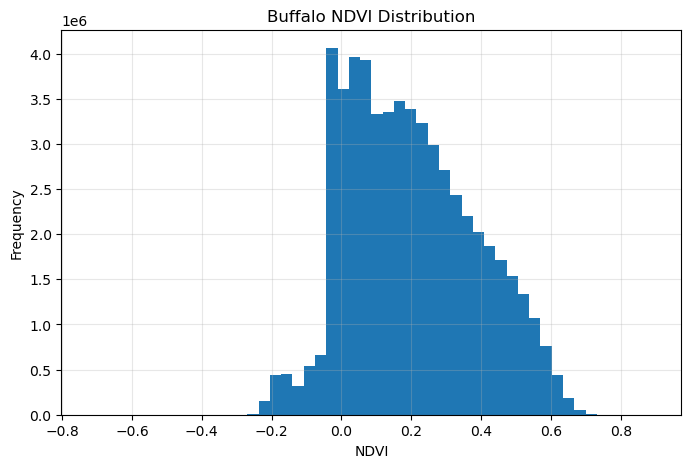

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import glob

# load all resampled NDVI rasters
files = sorted(glob.glob(str(RESAMP_DIR / "*.tif")))
print("Found", len(files), "resampled NDVI rasters")

all_vals = []

for f in files:
    with rasterio.open(f) as src:
        arr = src.read(1).astype(float)
        arr[arr == src.nodata] = np.nan
        arr = np.clip(arr, -1, 1)
        all_vals.append(arr.flatten())

all_vals = np.hstack(all_vals)
finite_vals = all_vals[np.isfinite(all_vals)]

plt.figure(figsize=(8,5))
plt.hist(finite_vals, bins=50)
plt.title("Buffalo NDVI Distribution")
plt.xlabel("NDVI")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

Interpretation:
A peak around 0.1–0.3 → urban vegetation, sparse tree cover.
A peak around 0.4–0.7 → parks, suburban vegetation.
NDVI < 0 → water or clouds.
Buffalo typically shows mixed urban + vegetation, so expect multiple bumps.

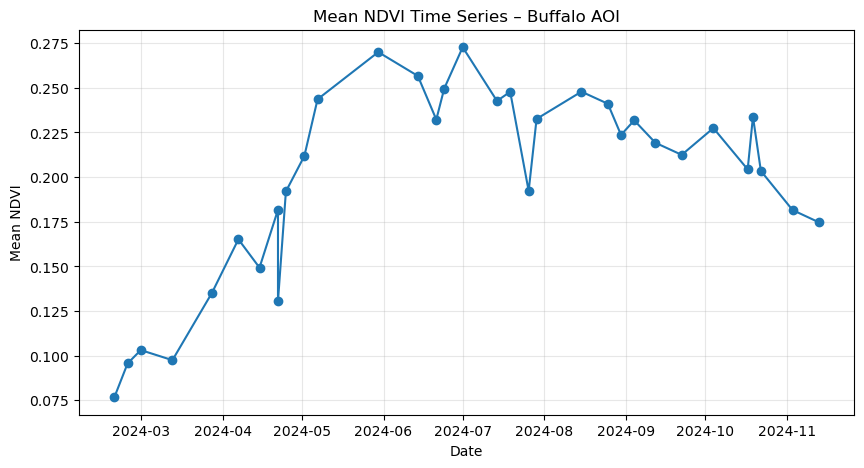

In [11]:
dates = []
means = []

for f, date in zip(files, df_clean['date']):
    with rasterio.open(f) as src:
        arr = src.read(1).astype(float)
        arr[arr == src.nodata] = np.nan
        arr = np.clip(arr, -1, 1)
        m = np.nanmean(arr)
        means.append(m)
        dates.append(date)

plt.figure(figsize=(10,5))
plt.plot(dates, means, marker='o')
plt.title("Mean NDVI Time Series – Buffalo AOI")
plt.xlabel("Date")
plt.ylabel("Mean NDVI")
plt.grid(alpha=0.3)
plt.show()


Interpretation
NDVI rises towards June–August, peaks mid-summer.
Drops sharply in fall, lowest in winter.
A jagged curve indicates clouds or incomplete vegetation coverage.

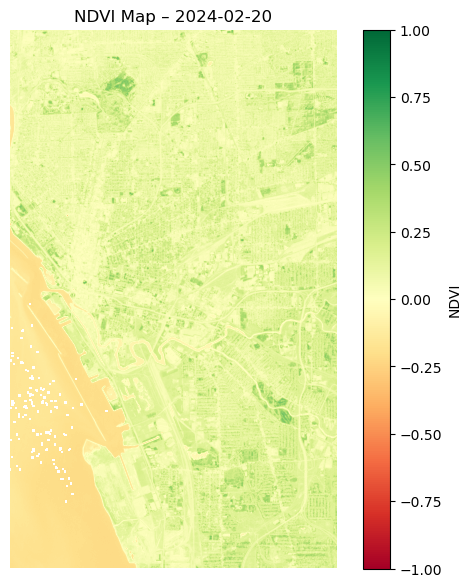

In [12]:
with rasterio.open(files[0]) as src:
    arr = src.read(1)
    arr = np.clip(arr, -1, 1)
    plt.figure(figsize=(7,7))
    plt.imshow(arr, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(label='NDVI')
    plt.title(f"NDVI Map – {df_clean['date'].iloc[0].date()}")
    plt.axis('off')


Colors:
Green = vegetation
Yellow/red = bare soil / urban
Blue/black = water or no data
Buffalo urban grid with greenery patches.

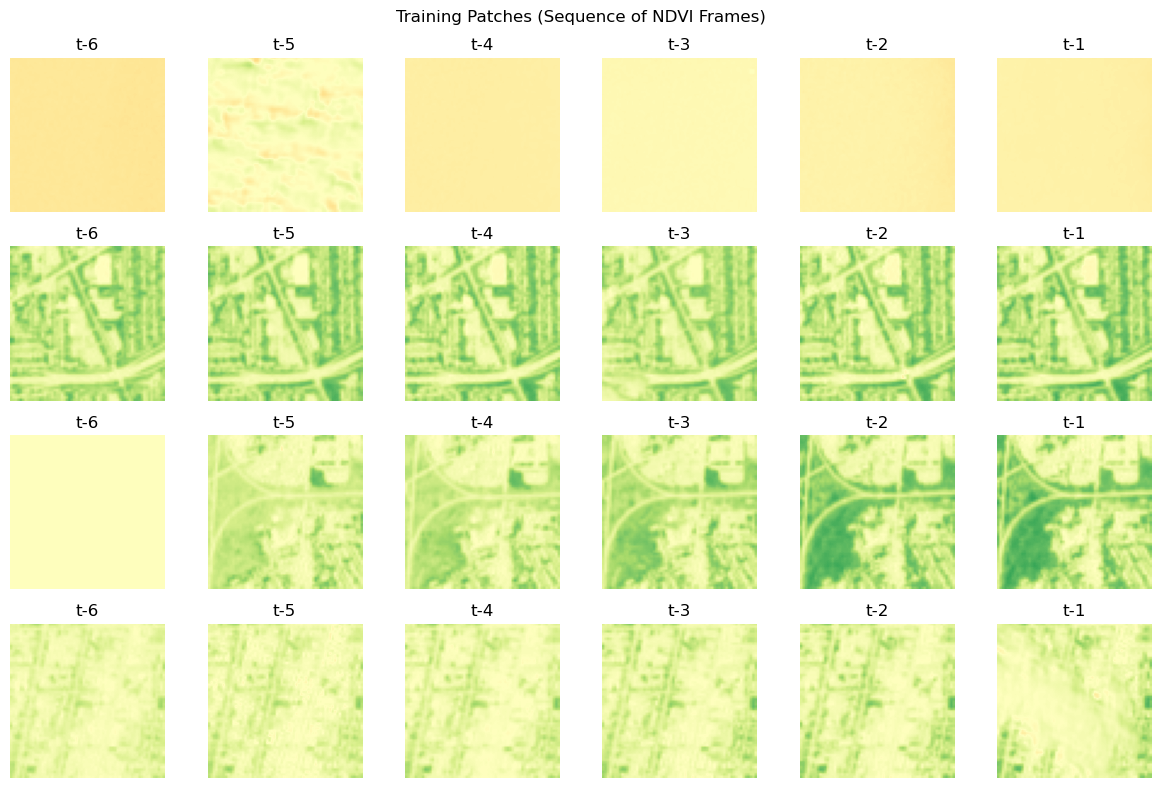

In [13]:
# grab some samples directly from the training dataset
import random

num_examples = 4
fig, axs = plt.subplots(num_examples, SEQ_LEN, figsize=(SEQ_LEN*2, num_examples*2))

for r in range(num_examples):
    idx = random.randint(0, len(train_ds)-1)
    X, T, y = train_ds[idx]  # X: (seq_len, 1, H, W)

    for t in range(SEQ_LEN):
        axs[r, t].imshow(X[t, 0].numpy(), cmap='RdYlGn', vmin=-1, vmax=1)
        axs[r, t].set_title(f"t-{SEQ_LEN-t}")
        axs[r, t].axis('off')

plt.suptitle("Training Patches (Sequence of NDVI Frames)")
plt.tight_layout()
plt.show()


Interpretation: Each row is a temporal sequence of the same patch location:
Left:older NDVI
Right:most recent before prediction
The model learns seasonal + spatial change:greening during spring/summer, browning during fall, stable urban areas,vegetation stress or regrowth.